In [4]:
!pip install resampy

  Using cached resampy-0.4.2-py3-none-any.whl (3.1 MB)


In [5]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import librosa
import librosa.display
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

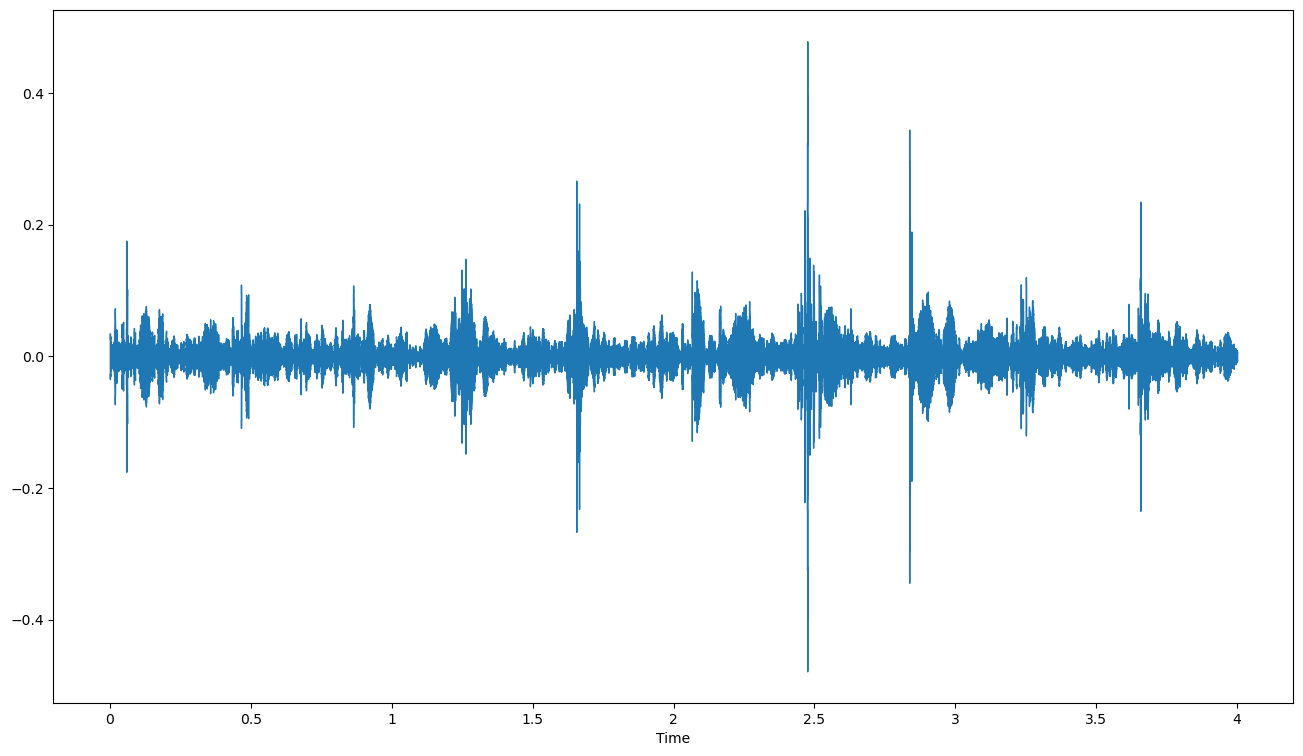

In [6]:
plt.figure(figsize=(16,9))
data,sample_rate=librosa.load('/kaggle/input/urbansound8k/fold1/203440-3-0-6.wav')
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio('/kaggle/input/urbansound8k/fold1/203440-3-0-6.wav')

In [7]:
sample_rate

22050

In [8]:
from scipy.io import wavfile as wav
wave_sample_rate,wave_audio=wav.read('/kaggle/input/urbansound8k/fold1/203440-3-0-6.wav')
wave_sample_rate

44100

In [9]:
wave_audio

array([[ 1643,    36],
       [ 1642,    91],
       [ 1695,   120],
       ...,
       [  638,  -966],
       [  633, -1019],
       [  643, -1006]], dtype=int16)

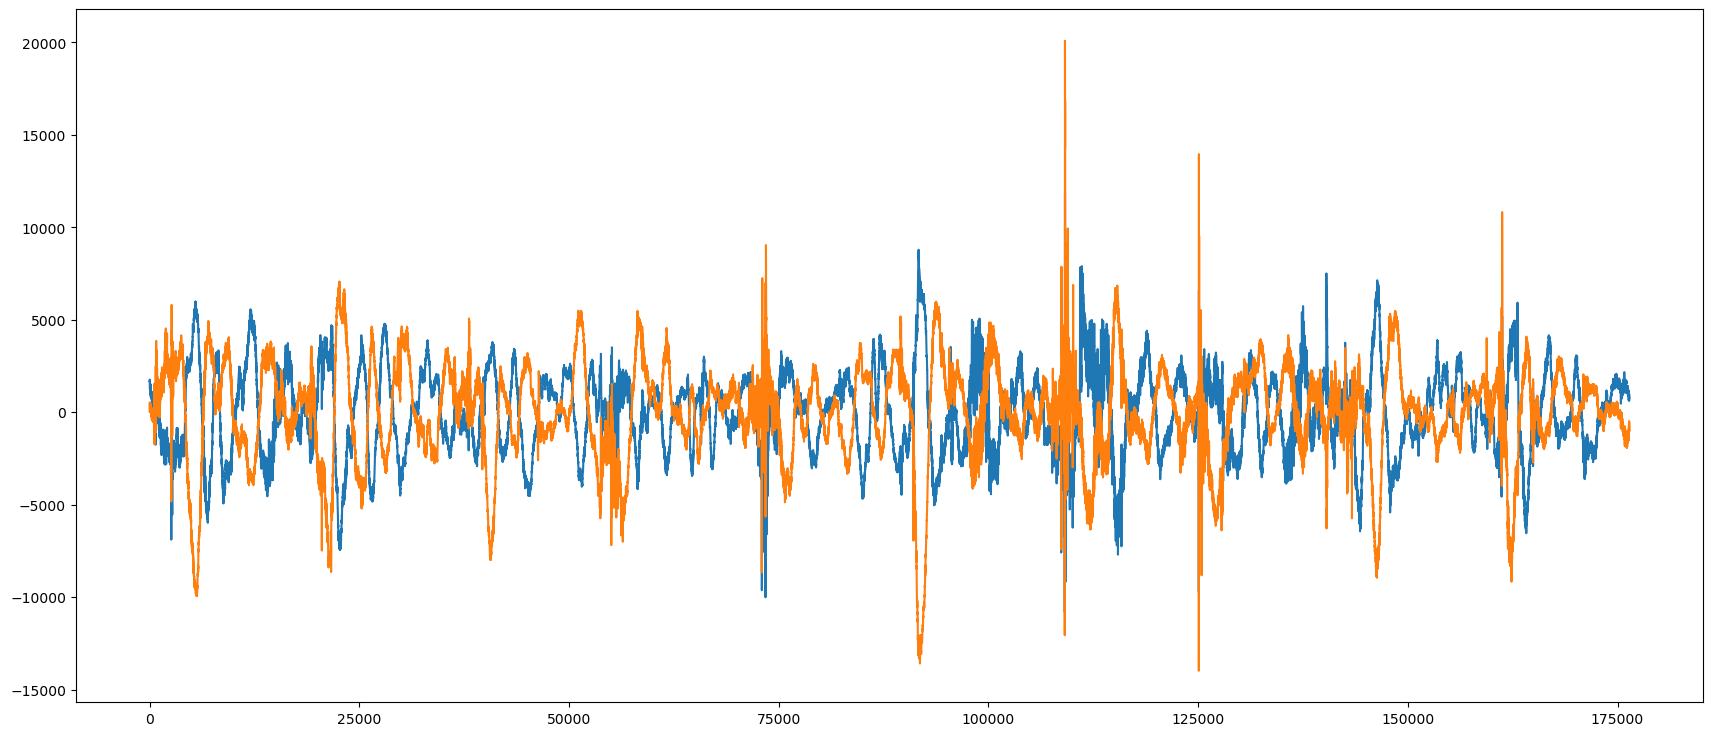

In [10]:
plt.figure(figsize=(21,9))
plt.plot(wave_audio)

In [11]:
data

array([ 0.01899232,  0.02967405,  0.02834449, ..., -0.00331641,
       -0.00448628, -0.00583735], dtype=float32)

In [12]:
metadata=pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [13]:
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [14]:
mfccs=librosa.feature.mfcc(y=data,sr=sample_rate,n_mfcc=40)
np.mean(mfccs.T,axis=0)

array([-3.3085321e+02,  1.2915570e+02, -2.0952625e+00,  1.0937165e+01,
        1.1640263e+01,  1.6167286e+01,  7.8123732e+00,  7.0209002e+00,
        5.4834900e+00,  8.2991114e+00,  3.9884098e+00,  5.4555216e+00,
        3.0526285e+00,  4.3427176e+00, -6.8579227e-01,  5.7752643e+00,
        1.9170702e+00,  4.0369701e+00, -1.4787871e+00,  2.1035676e+00,
        3.3253124e+00,  6.3088279e+00,  2.9356902e+00,  4.9363003e+00,
       -6.9200975e-01,  3.0525794e+00,  7.2725154e-02,  4.6492372e+00,
        1.2050881e-01,  1.6248683e+00, -1.1719041e+00,  3.0364757e+00,
        3.0194026e-01,  3.1116121e+00, -1.7656581e+00,  1.9187721e+00,
       -1.2394658e+00,  3.3053126e+00, -9.9237424e-01,  1.3503360e+00],
      dtype=float32)

In [15]:
audio_dataset_path='/kaggle/input/urbansound8k/'

In [16]:
def feature_extractor(filename):
    audio,sample_rate=librosa.load(filename,res_type='kaiser_fast')
    mfccs_features=librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    mfccs_scaled_features=np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

In [17]:
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name=os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row['slice_file_name']))
    final_class_labels=row['class']
    data=feature_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [08:14,  6.55it/s]/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
8324it [18:52, 10.46it/s]/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
8327it [18:52, 13.95it/s]/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
8732it [19:45,  7.37it/s]


In [18]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66371, -35.42945, 53.036354, ...",children_playing
4,"[-446.60352, 113.68541, -52.402214, 60.302044,...",children_playing
...,...,...
8727,"[-398.5845, 135.53496, -50.725018, 35.855907, ...",car_horn
8728,"[-346.4742, 86.34815, -45.16858, 51.709873, -3...",car_horn
8729,"[-303.88824, 111.35945, -45.941566, 35.877018,...",car_horn
8730,"[-344.11008, 125.45021, -54.903442, 34.891155,...",car_horn


In [19]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [20]:
X.shape

(8732, 40)

In [21]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [22]:
# y=np.array(pd.get_dummies(y))
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [23]:
y.shape

(8732, 10)

In [24]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape

(6985, 40)

In [25]:
y_train.shape

(6985, 10)

In [26]:
num_labels=y.shape[1]

In [27]:
model=Sequential()
#first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#final layer
model.add(Dense(num_labels))
model.add(Activation(tf.keras.activations.softmax))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [29]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [30]:
epochs=100
batch_size=32

checkpointer=ModelCheckpoint(filepath='saved_models/BISAG_project.hdf5',verbose=1,save_best_only=True)

start=datetime.now()

model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_test,y_test),callbacks=[checkpointer],use_multiprocessing=True)

time_required=datetime.now()-start

print("Trainig completed in time:",time_required)

Epoch 1/100
203/219 [==========================>...] - ETA: 0s - loss: 11.2882 - accuracy: 0.1256
Epoch 1: val_loss improved from inf to 2.28657, saving model to saved_models/BISAG_project.hdf5
219/219 [==============================] - 5s 5ms/step - loss: 10.6955 - accuracy: 0.1261 - val_loss: 2.2866 - val_accuracy: 0.1242
Epoch 2/100
203/219 [==========================>...] - ETA: 0s - loss: 2.5352 - accuracy: 0.1207
Epoch 2: val_loss improved from 2.28657 to 2.26999, saving model to saved_models/BISAG_project.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 2.5257 - accuracy: 0.1200 - val_loss: 2.2700 - val_accuracy: 0.1259
Epoch 3/100
218/219 [============================>.] - ETA: 0s - loss: 2.3206 - accuracy: 0.1395
Epoch 3: val_loss improved from 2.26999 to 2.21482, saving model to saved_models/BISAG_project.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 2.3220 - accuracy: 0.1394 - val_loss: 2.2148 - val_accuracy: 0.1752
Epoch 4/100
204/21

In [46]:
test_accuracy=model.evaluate(X_test,y_test)
test_accuracy[1]

55/55 [==============================] - 0s 3ms/step - loss: 0.7988 - accuracy: 0.7459


0.7458500266075134

In [47]:
prediction_features=feature_extractor('/kaggle/input/urbansound8k/fold1/203440-3-0-6.wav')
prediction_features=prediction_features.reshape(1,-1)
model.predict(prediction_features)

1/1 [==============================] - 0s 43ms/step


array([[0.19995944, 0.01267489, 0.25822094, 0.0978999 , 0.06826968,
        0.07999966, 0.05666425, 0.02974077, 0.06761917, 0.12895127]],
      dtype=float32)

In [54]:
#testing a sample audio
filename='/kaggle/input/urbansound8k/fold1/203440-3-0-6.wav'
audio,sample_rate=librosa.load(filename,res_type='kaiser_fast')
mfccs_features=librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
mfccs_scaled_features=np.mean(mfccs_features.T,axis=0)
# pred_vector = np.argmax(model.predict(mfccs_scaled_features), axis=-1)
pred_vector = np.argmax(model.predict(np.expand_dims(mfccs_scaled_features, axis=0)), axis=-1)

1/1 [==============================] - 0s 38ms/step


In [55]:
prediction_class=labelencoder.inverse_transform(pred_vector)
prediction_class

array(['children_playing'], dtype='<U16')